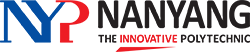

# ITB251 Assignment - Task 1: Sentiment Classification

You are required to build a sentiment classification model predict the sentiment of the review text. Businesses will be able to use this model to predict the sentiment of a new review.

Complete the following sub-tasks:
1.	**Data Understanding**: Examine the dataset
2.	**Data Preparation**: Prepares the data and all necessary pre-processing tasks
3.	**Modelling**: Use different text representation and modelling algorithms
4.	**Evaluation**: Evaluates results from the algorithms and select the best model

For each sub-task, perform the necessary steps and **explain the rationale taken for each step in this Jupyter notebook**. 

**Done by: Andrew Fang 212579B**

## Import libraries and download the packages

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
from nltk.probability import FreqDist

## Read the dataset

In [2]:
df = pd.read_csv("shopping_reviews.csv")
df.head(3)

,Unnamed: 0,review_id,date,name,categories,text,stars
0,15,Af6Jnf8F5xBliuixStWF8g,2019-09-20,"""Soccer Zone""",Shopping;Sporting Goods,I'll admit it. I caught World Cup fever in 20...,4
1,18,j-6-I55-9EiKNGAjoLHx9A,2020-06-30,"""Fye""",Shopping;Books;Mags;Music & Video;Music & DVDs,This store has gone through some management ch...,4
2,46,wCwl4NC1CxkRIAg2RcLzig,2020-09-28,"""By Design""",Home & Garden;Furniture Stores;Shopping,By Design sells funky ultra modern furniture. ...,3


## Data Understanding
Perform the necessary steps and explain the rationale taken here.



In [3]:
print("Number of records in the dataframe:",df.shape[0])
print("Number of columns in the dataframe:",df.shape[1])

Number of records in the dataframe: 36422
Number of columns in the dataframe: 7


In [4]:
print("Columns in the dataframe:")
df.columns

Columns in the dataframe:


Index(['Unnamed: 0', 'review_id', 'date', 'name', 'categories', 'text',
       'stars'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36422 entries, 0 to 36421
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  36422 non-null  int64 
 1   review_id   36422 non-null  object
 2   date        36422 non-null  object
 3   name        36422 non-null  object
 4   categories  36422 non-null  object
 5   text        36422 non-null  object
 6   stars       36422 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 1.9+ MB


The index of the dataframe ranges from 0 to 36421.

The datatype of the columns seem to be correct.

In [6]:
print("Percentage of null in the columns:")
df.isna().sum()/df.shape[0]

Percentage of null in the columns:


Unnamed: 0    0.0
review_id     0.0
date          0.0
name          0.0
categories    0.0
text          0.0
stars         0.0
dtype: float64

There are no null values in any of the columns.

### Data Understanding - Columns 'Unnamed: 0' and 'review_id'

In [7]:
print("How unique are the Unnamed: 0 and review_id?")
print("Uniqueness Percentage of column 'Unnamed: 0':",(df['Unnamed: 0'].nunique()/df.shape[0])*100)
print("Uniqueness Percentage of column 'review_id':",(df['review_id'].nunique()/df.shape[0])*100)

How unique are the Unnamed: 0 and review_id?
Uniqueness Percentage of column 'Unnamed: 0': 100.0
Uniqueness Percentage of column 'review_id': 100.0


A uniqueness percentage of 100% means that it is 100% unique.

These columns are unique identifiers for each record in the dataframe. They have high dimensionality and are not relevant to the target, which is to classify the positive and negative texts. Therefore, these columns will be removed later.

### Data Understanding - Columns 'date'

In [8]:
print("Earlist text recorded:",df.date.min())
print("Latest text recorded:",df.date.max())

Earlist text recorded: 2019-01-01
Latest text recorded: 2020-12-31


The dataframe contains data from 2019 to 2020, 2 years worth of data.

In [9]:
# Convert the date column to datetype column
df['yyyy-mm'] = pd.to_datetime(df.date).dt.strftime('%Y-%m')

# Get unique months and number of records in respective month
months = sorted(df['yyyy-mm'].unique())
occurrence = list(df.groupby('yyyy-mm').size())

# Zip the months and its respective occurrence
occurrence_month = list(zip(months, occurrence))

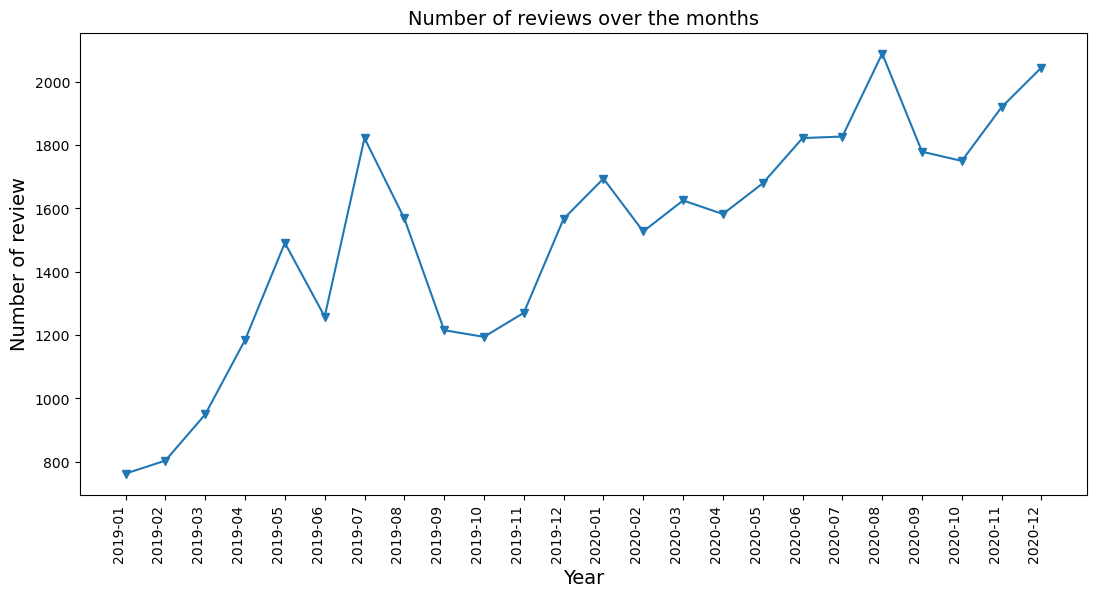

In [10]:
# Checking the distribution of reviews across the time period
fig = plt.figure(figsize=(13, 6))
plt.plot(sorted(df['yyyy-mm'].unique()), df.groupby('yyyy-mm').size(), marker='v')
plt.xticks(rotation=90, ha='right')
plt.title('Number of reviews over the months', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of review', fontsize=14)
plt.show()

In [11]:
print("Difference between the highest and lowest number of reviews:",max(occurrence)-min(occurrence))

Difference between the highest and lowest number of reviews: 1327


Based on the line chart, the spread of reviews across the months is fairly distributed with each month having at least 700 records. The difference between the highest and lowest review months being 1327 reviews.

### Data Understanding - Columns 'name'

In [12]:
print("Number of unique store names in the dataframe:",df.name.nunique())

Number of unique store names in the dataframe: 7475


This dataframe contains lots of unique store names. Therefore, I will not analyze the spread of sentiment across individual stores.

In [13]:
# Check if the top store name is null or any weird value.
df.name.value_counts()

"Encore"                          408
"Trader Joe's"                    395
"Target"                          313
"Walmart Supercenter"             306
"Total Wine & More"               246
                                 ... 
"David's Shoes"                     1
"Yes of Course"                     1
"Sporting Life Bikes & Boards"      1
"Million Tapis et Tuiles"           1
"Fresh Boutique"                    1
Name: name, Length: 7475, dtype: int64

Based on the counts, there seems to not have any weird values apart from occasional weird store names such as 'Yes of Course'.

In [14]:
print("Percentage of stores that have 1 review only in the dataframe:",round((((df.groupby(df.name.tolist()).size() == 1).sum())/df.shape[0])*100),"%")

Percentage of stores that have 1 review only in the dataframe: 8 %


The number of stores that have only 1 review belongs to roughly 8% of the records in the dataframe.

The other 92% belongs to stores that have more than 1 reviews of their store.

### Data Understanding - Columns 'categories'

In [15]:
print("Number of unique categories in the dataframe:",df.categories.nunique())

Number of unique categories in the dataframe: 6568


In [16]:
df.categories.head()

0                           Shopping;Sporting Goods
1    Shopping;Books;Mags;Music & Video;Music & DVDs
2           Home & Garden;Furniture Stores;Shopping
3      Nurseries & Gardening;Home & Garden;Shopping
4                           Sporting Goods;Shopping
Name: categories, dtype: object

The categories seem to be clustered with a separator ';'. 

Therefore, the value 6568 identified earlier represents the group of categories, not the individual categories.

In order to have a better data exploration, these categories need to be separated.

In [17]:
# Store the categories in a list for manipulation.
categories = [category for category in df['categories']]

In [18]:
# Iterate through the list and substitute the ';' with spaces.
# Convert categories with '&' to be joined with an underscore.
strip = list(map(lambda x: re.sub(';', ' ', re.sub('[ &()]+', '_', x)), categories))
strip[:5]

['Shopping Sporting_Goods',
 'Shopping Books Mags Music_Video Music_DVDs',
 'Home_Garden Furniture_Stores Shopping',
 'Nurseries_Gardening Home_Garden Shopping',
 'Sporting_Goods Shopping']

In [19]:
# Tokenize the individual categories
tokenized_category_list = [sorted(nltk.word_tokenize(category)) for category in strip]

In [20]:
# Store all categories (regardless of duplicates)
category_list = [category for lists in tokenized_category_list for category in lists]

In [21]:
# Extract the unique categories
unique_categories = set(category_list)

In [22]:
print('Number of unique categories in the dataframe:',len(unique_categories))

Number of unique categories in the dataframe: 678


In [23]:
print("Example of categories in the dataframe")
list(unique_categories)[:5]

Example of categories in the dataframe


['Pet_Sitting', 'Car_Auctions', 'Mags', 'Comedy_Clubs', 'Makeup_Artists']

In [24]:
print("Top 10 categories in the dataframe")
pd.value_counts(category_list).head(10)

Top 10 categories in the dataframe


Shopping             36422
Fashion              11061
Food                  5150
Home_Garden           4994
Women's_Clothing      4346
Flowers_Gifts         3191
Department_Stores     3188
Music_Video           2796
Mags                  2796
Books                 2796
dtype: int64

The categories give a general idea of what type of stores the texts are from. 

The texts are from mostly related to shopping, fashion, food, and others.

### Data Understanding - Columns 'text'

In [25]:
df.text.head()

0    I'll admit it.  I caught World Cup fever in 20...
1    This store has gone through some management ch...
2    By Design sells funky ultra modern furniture. ...
3    I don't have much of a greenthumb, thankfully ...
4    I am only ever going to this Sports Authority ...
Name: text, dtype: object

This will be the column used for text classification. It contains the customer's review toward the store and contains words that affect the overall text sentiment.

In [26]:
print("Percentage of unique texts in the dataframe",(df.text.nunique()/df.shape[0])*100,"%")

Percentage of unique texts in the dataframe 99.97254406677283 %


There seem to have some duplicates in the text since the percentage is not 100% unique.

### Data Understanding and Preparation - Checking and Removing duplicates in text column.

In [27]:
print("Percentage of unique texts in the dataframe",(df.text.nunique()/df.shape[0])*100,"%")

Percentage of unique texts in the dataframe 99.97254406677283 %


In [28]:
print("Number of duplicated texts:",len(df[df.duplicated(subset='text')]))

Number of duplicated texts: 10


In [29]:
df[df.duplicated(subset='text')].head()

,Unnamed: 0,review_id,date,name,categories,text,stars,yyyy-mm
4454,44208,ap04xvg5qzR3Z_NyplaWoQ,2019-07-03,"""Clinton Cards""",Art Supplies;Shopping;Flowers & Gifts;Cards & ...,I have to be honest and say I don't really see...,2,2019-07
20561,212655,063_M7x370zH_tTPsSkTzQ,2020-11-04,"""Ace Hardware""",Hardware Stores;Home & Garden;Shopping,Union Hills Ace Hardware is really great.. the...,5,2020-11
21345,221974,q2gxE-9bxP85opJGS5bm3A,2020-12-31,"""Urban Outfitters""",Home & Garden;Fashion;Women's Clothing;Shoppin...,Score! When I went over Christmas they were ha...,4,2020-12
21510,223196,RPj6HJ25oV5KqH-dbgkYhA,2020-02-20,"""Sephora""",Cosmetics & Beauty Supply;Beauty & Spas;Shopping,I love Sephora. The associates are always fri...,5,2020-02
23959,246519,6lpuDI4PrrUY_5lWcV8vug,2020-05-10,"""Mega Furniture""",Home & Garden;Furniture Stores;Shopping;Mattre...,Too good to be true...because its not true! I ...,1,2020-05


Looking at the text duplicates, the length of the texts are long and highly unlikely that the reviewers wrote the same text as another person. Thus, I will drop these records to prevent overfitting and reduce noise in the model.

In [30]:
# Drop the duplicates
df = df.drop_duplicates(subset=['text'])

In [31]:
# Resetting the index of the dataframe
df = df.reset_index(drop=True)

In [32]:
print("Number of records in the dataframe now:",df.shape[0])

Number of records in the dataframe now: 36412


### Data Understanding - Columns 'star'

Total records: 36412


stars,occurrences,occurrences (%)
5,12606,34.62%
4,11983,32.91%
3,5691,15.63%
1,3326,9.13%
2,2806,7.71%


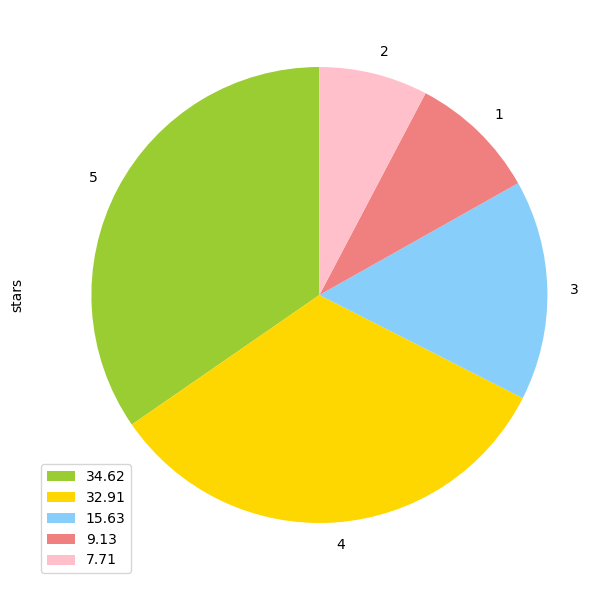

In [33]:
# Checking the distribution of the stars
stars = pd.DataFrame({'occurrences': df['stars'].value_counts(),
                      'occurrences (%)': [str(round((x/len(df)*100), 2))+"%" for x in df['stars'].value_counts()]}).rename_axis(columns="stars")
print("Total records:", sum(stars['occurrences']))
display(stars)

labels = round((df['stars'].value_counts()/len(df)*100),2)
sizes = round((df['stars'].value_counts()/len(df)*100),2)
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'pink']
(df['stars'].value_counts()/len(df)*100).plot(kind='pie', figsize=(14,6), colors=colors, startangle=90)
plt.legend(labels, loc="best")
plt.tight_layout()
plt.show()

- The star ratings range from 1 to 5. The ratio of 4 to 5 stars to 1 to 2 stars is unproportionate, with a ratio of 67.53% to 16.84%. 


- Overall, most reviewers gave their stores a rating of 4 to 5.


- Data Balancing and Sampling is required to balance the number of stars in the dataframe to ensure the model is not overfitted or biased toward a star rating.

### Data Preparation - Removing star ratings of 3 and Replacing stars column

I create a new column 'sentiment' and assign records with 1 or 2 stars as 'negative', while 4 and 5 stars as 'positive'.

As for texts with a star rating of 3, I assume that the text is neutral; the text may contain either both positive and negative sentiments or none. Since I'm interested in classifying texts into positive or negative classes only so that the business is able to know their customer's sentiment toward their product or service without a grey area (neutral ratings), I will remove records with 3 stars.

In [34]:
# Removing reviews that have a star rating of 3 as it is neutral.
df = df[df.stars!=3]

In [35]:
print("Number of records left after removing records with a rating of 3:",df.shape[0])

Number of records left after removing records with a rating of 3: 30721


In [36]:
# Stars value 4 and above is positive, 2 and below is negative.
df['sentiment'] = ''
df.loc[lambda df: df['stars'] >= 4, 'sentiment'] = 'positive'
df.loc[lambda df: df['stars'] <= 2, 'sentiment'] = 'negative'

In [37]:
df = df.drop(columns=['stars'])

In [38]:
df.head(1)

,Unnamed: 0,review_id,date,name,categories,text,yyyy-mm,sentiment
0,15,Af6Jnf8F5xBliuixStWF8g,2019-09-20,"""Soccer Zone""",Shopping;Sporting Goods,I'll admit it. I caught World Cup fever in 20...,2019-09,positive


Total records: 30721


sentiment,occurrences,occurrences (%)
positive,24589,80.04%
negative,6132,19.96%


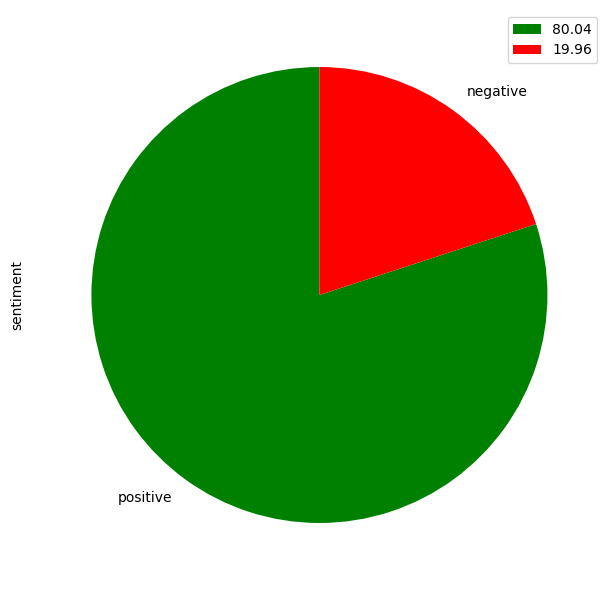

In [39]:
# Checking the distribution of the sentiments
sentiments = pd.DataFrame({'occurrences': df['sentiment'].value_counts(),
                      'occurrences (%)': [str(round((x/len(df)*100), 2))+"%" for x in df['sentiment'].value_counts()]}).rename_axis(columns="sentiment")
print("Total records:", sum(sentiments['occurrences']))
display(sentiments)

labels = round((df['sentiment'].value_counts()/len(df)*100),2)
sizes = round((df['sentiment'].value_counts()/len(df)*100),2)
colors = ['green','red']
(df['sentiment'].value_counts()/len(df)*100).plot(kind='pie', figsize=(14,6), colors=colors, startangle=90)
plt.legend(labels, loc="best")
plt.tight_layout()
plt.show()

The ratio of sentiments positive to negative is 80% to 20% respectively, which is unbalanced.

Therefore, to prevent a biased and overfitted model, data balancing will be performed later.

### Data Understanding - Checking the Word and Word Length Distribution

In [40]:
# Store reviews in a variable
reviews = [review.lower() for review in df['text']]

In [41]:
# Tokenize the words
from nltk.tokenize import word_tokenize

tokenized_words = [word_tokenize(review) for review in reviews]

In [42]:
# Get the tokenized words
tokenized_word_list = [word for word_lists in tokenized_words for word in word_lists]

# Get the word lengths
word_lengths = [len(word) for word in tokenized_word_list]

#### Word Length Distribution

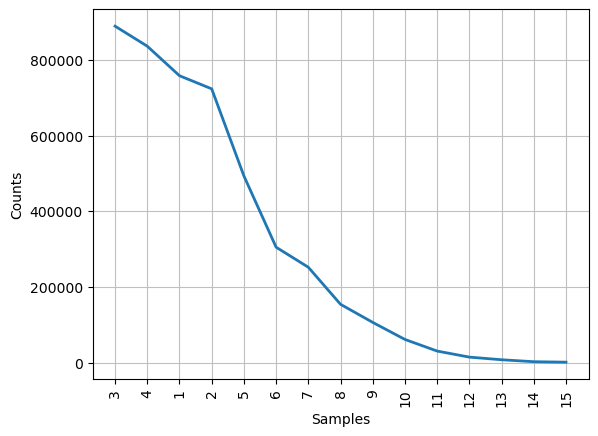

In [43]:
# Generate frequency for all the words
freq_dist = nltk.FreqDist(word_lengths)

# Visualizing 
word_length_frequency_dict = dict([(k,v) for k,v in freq_dist.items()])

# create frequency distribution of the filtered words
freq_dist = nltk.FreqDist(word_length_frequency_dict)

# plot the frequency distribution of the top 50 words
freq_dist.plot(15, cumulative=False)
plt.show()

### Identifying odd words that need to be removed.

These words will create noise during sentiment analysis. Therefore, to ensure optimal model performance, these specific odd words will be removed without removing potentially useful terms.

#### Identifying words with odd lengths

In [44]:
# At word lengths of more than 10, the curve starts to flat line.
# Therefore, look at the words with length above 10.

odd_lengths = [words for words in tokenized_word_list if len(words)>10]
print(odd_lengths[:10])

['well-stocked', 'neighborhood', 'disappointed', 'accompanied', 'recommended', 'immediately', '\\/\\/www.yelp.com\\/biz_photos\\/xpzt3zlrklkfskbvxssm3w', 'select=n2iluoe8xdytbiowpfnp3q', 'wedding-related', 'researching']


- There seems to be some links in the texts such as "\\/\\/www.yelp.com\\/biz_photos\\/xpzt3zlrklkfskbvxssm3w". These links start with '\\\\\/'

- There also seems to be SQL-like statements such as "select=n2iluoe8xdytbiowpfnp3q"

- Lastly, the word "\\\\/" seems like it is used as a slash in the links.

In [45]:
# Confirming if '\\\\/' is used as a slash
slashed_words = [words for words in tokenized_word_list if '\\/' in words]
print(slashed_words[5:20])

['bought\\/returned', '£5\\/10', 'situations\\/patrons', 'board\\/ride', 'sf\\/us', 'you\\/goodbye', 'and\\/or', 'bed\\/bath\\/kitchen', 'climbing\\/sliding', 'playground\\/cermaic', '12\\/22\\/2011', '12\\/23\\/2011', '12\\/23\\/2011', '12\\/25\\/2009', 'tv\\/cell']


To confirm, the \\\\/ is used as a slash.

In [46]:
# Checking for words with '.' in odd length words
# This could help us identify website links within the words with long lengths
dots_in_text = [word for word in odd_lengths if '.' in word]
print(dots_in_text[:10])

['\\/\\/www.yelp.com\\/biz_photos\\/xpzt3zlrklkfskbvxssm3w', 'store.highly', '....................', '...............................', 'www.bohofarmandhome.com', 'bohofarmandhome.com', '\\/\\/www.saleevent.ca\\/index.php', '\\/\\/www.artomat.org\\/home.html', '\\/\\/www.dovenetq.net.au\\/~mahayes\\/graphics\\/yeslogofullcircle1.jpg', '\\/\\/www.vinylrecords.ch\\/b\\/bo\\/boston\\/boston\\/boston-63.jpg']


- Looks like there are some links aside from the yelp link identified above.
- Some links start with www while others end with their domain names.
- There are words that could have been typed wrongly e.g., store.highly

In [47]:
# Checking for domain names
# Since .com is a domain name, 
# I try to find other domain names and remove words containing them.

# pattern to identify the domain names at the end of the words
pattern = '\.[\w+\d+]+$'

organizations = [re.findall(pattern, words) for words in dots_in_text if re.findall(pattern, words)]

compiled_values = [value for lists in organizations for value in lists]

compiled_array = np.array(compiled_values)
occurrence = list(zip(*np.unique(compiled_array, return_counts=True)))

# Store the domain names
domains_names = ['('+str(entry[0].strip('.'))+')' for entry in occurrence if entry[1]>1]

In [48]:
domain_names = sorted(domains_names, key=len, reverse=True)
# Sort them based on their length so that domains such as 'html' will not be replaced by 
# 'htm' instead of 'html'.
regex_domain_names = '|'.join(domain_names)
regex_domain_names

'(customer)|(highly)|(their)|(there)|(also)|(aspx)|(html)|(save)|(then)|(they)|(this)|(time)|(what)|(all)|(and)|(asp)|(cfm)|(com)|(htm)|(jpg)|(net)|(now)|(org)|(pdf)|(php)|(she)|(the)|(yes)|(you)|(ca)|(de)|(if)|(it)|(on)|(uk)|(we)|(i)'

This list of domain names will be used for pattern matching later.

In [49]:
# Checking for words with '.' in odd length words
# This could help us identify website links within the words with long lengths
colon_text = [word for word in tokenized_word_list if ':' in word]
print(colon_text[:10])

[':', ':', ':', ':', ':', ':', '5:00', '5:30pm', ':', ':']


In [50]:
http_occurrences = [words for words in odd_lengths if ':' in words]
print(http_occurrences[:5])

['2:30-5:15pmish', 'hrid:9eqwucmwj79em_obubuyha', '09:00-11:00.', '11:50-something', '2:30pm-4:30pm']


There are some colons in the text.

In [51]:
print([word for word in tokenized_word_list if '=' in word][:10])

['select=n2iluoe8xdytbiowpfnp3q', '=', '=', 'two=', '=', '=p', '=d', '=', 'select=apvssppowbz3lb0ob4saua', 'select=iwbx1a-hrgvir4fm8qhjhq']


Seems like most of the SQL-like syntax has numbers, punctuations, or special characters in the words following the "=".

In [52]:
http_occurrences = [words for words in tokenized_word_list if 'http' in words]
print(http_occurrences[:5])

['http', 'http', 'http', 'http', 'http']


There are some 'http' words in the tokenized words. There seems to not have any links, but just http

In [53]:
print([http for http in http_occurrences if len(http)>4])

['https', 'https', 'https', 'https', 'https', 'https', 'guisehttp', 'https', 'https']


Looks like there are https and words in front of http, but not any link. Therefore, these needs to be removed.

### Checking the word distribution

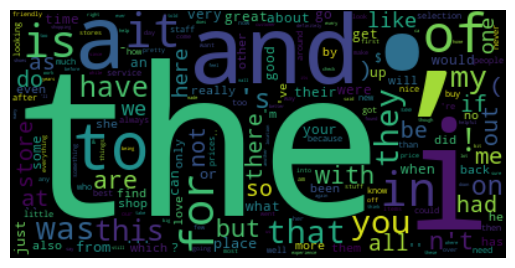

In [54]:
# Generate frequency for all the words
freq_dist = nltk.FreqDist(tokenized_word_list)

# Visualizing 
words = dict([(k,v) for k,v in freq_dist.items()])

# create frequency distribution of the filtered words
freq_dist = nltk.FreqDist(words)

# build wordcloud
from wordcloud import WordCloud
wcloud = WordCloud().generate_from_frequencies(freq_dist)

# plot the wordcloud
import matplotlib.pyplot as plt
plt.imshow(wcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Words with high frequency appear larger in the word cloud.

Based on the word cloud and frequency distribution chart, the largest words are mostly stopwords or punctuations. These words occur frequently in all documents and will cause noise in the sentiment classifcation. Thus, it will be removed later to prevent it from affecting the model's performance.

# Data Preparation
Perform the necessary steps and explain the rationale taken here.



#### Removing Unnecessary Columns to improve processing performance

Removing 'review_id' and 'Unnamed: 0'. As identified earlier, they are unique identifiers, have high dimensionality, and have no effect on the text's sentiment.

Removing 'date', 'categories' and 'name'. These columns have no effect on the text's sentiment nor will it be used.

Therefore, these columns are removed due to its low relevancy.

In [55]:
# Removing the columns
df = df.drop(columns=['review_id', 'Unnamed: 0', 'date', 'categories', 'name', 'yyyy-mm'])

In [56]:
df.head()

,text,sentiment
0,I'll admit it. I caught World Cup fever in 20...,positive
1,This store has gone through some management ch...,positive
3,"I don't have much of a greenthumb, thankfully ...",positive
4,I am only ever going to this Sports Authority ...,positive
5,"Looking for a new driver for my golf game, I s...",positive


#### Balancing and Sampling the Data

Total records: 30721


stars,occurrences,occurrences (%)
positive,24589,80.04%
negative,6132,19.96%


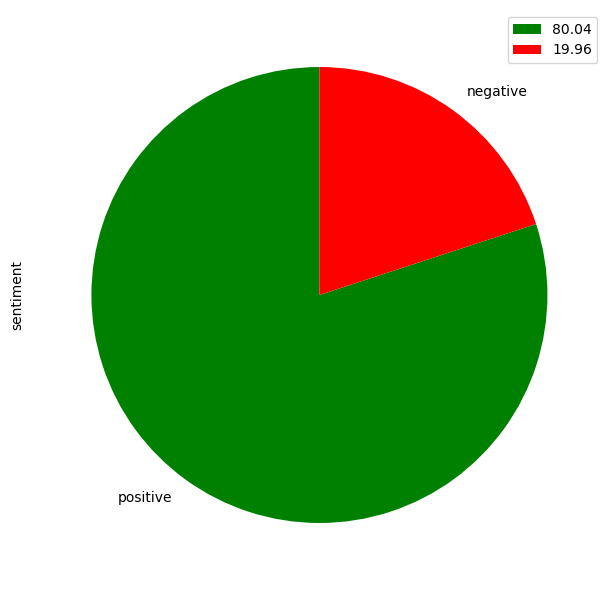

In [57]:
# Checking the distribution of the stars
sentiments = pd.DataFrame({'occurrences': df['sentiment'].value_counts(),
                      'occurrences (%)': [str(round((x/len(df)*100), 2))+"%" for x in df['sentiment'].value_counts()]}).rename_axis(columns="stars")
print("Total records:", sum(sentiments['occurrences']))
display(sentiments)

labels = round((df['sentiment'].value_counts()/len(df)*100),2)
sizes = round((df['sentiment'].value_counts()/len(df)*100),2)
colors = ['green', 'red']
(df['sentiment'].value_counts()/len(df)*100).plot(kind='pie', figsize=(14,6), colors=colors, startangle=90)
plt.legend(labels, loc="best")
plt.tight_layout()
plt.show()

The ratio of positive to negative sentiments is 80%:20% respectively, which is unbalanced. Unbalanced class may cause the model to be biased toward the majority class, positive sentiment, or overfitted.

To prevent a biased and/or overfitted model, I decided to perform undersampling on the majority class, while keeping all the data of the minority class, negative sentiment.

My Approach:
- I will undersample the majority class, positive sentiment, to contribute 60% of the dataframe.

Reason:
- A ratio of 60:40 for positive:negative ensures that the positive class retains majority of its original data and be a representative sample for the positive class.

In [58]:
number_for_sixty = (len(df[df['sentiment']=='negative'])/40)*60

df2 = pd.concat([df[df['sentiment']=='positive'].sample(n=int(number_for_sixty), random_state=42), df[df['sentiment']=='negative']], axis=0)

# To ensure the same data is sampled and reproduable results, I set a random_state of 42 for the sample function.

In [59]:
 df2 = df2.reset_index(drop=True)

Total records: 15330


stars,occurrences,occurrences (%)
positive,9198,60.0%
negative,6132,40.0%


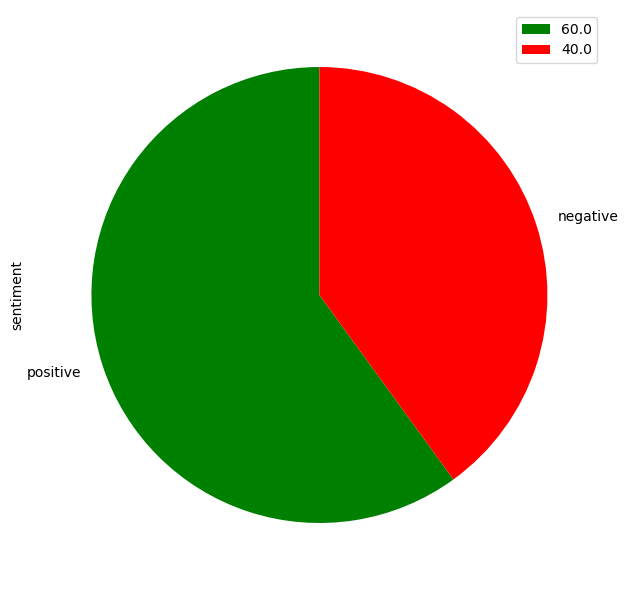

In [60]:
# Checking the distribution of the stars
sentiments = pd.DataFrame({'occurrences': df2['sentiment'].value_counts(),
                      'occurrences (%)': [str(round((x/len(df2)*100), 2))+"%" for x in df2['sentiment'].value_counts()]}).rename_axis(columns="stars")
print("Total records:", sum(sentiments['occurrences']))
display(sentiments)

labels = round((df2['sentiment'].value_counts()/len(df2)*100),2)
sizes = round((df2['sentiment'].value_counts()/len(df2)*100),2)
colors = ['green', 'red']
(df2['sentiment'].value_counts()/len(df2)*100).plot(kind='pie', figsize=(14,6), colors=colors, startangle=90)
plt.legend(labels, loc="best")
plt.tight_layout()
plt.show()

Now, the data is balanced and fit for sentiment analysis.

### Converting the Target Variable to Numbers

Machine Learning Models can not work on categorical variables in the form of strings, so we need to change it into numerical form.

In [61]:
df2.loc[lambda df2: df2['sentiment'] == 'positive', 'sentiment'] = 1
df2.loc[lambda df2: df2['sentiment'] == 'negative', 'sentiment'] = 0

In [62]:
pd.set_option("display.max_colwidth", None)
df2.head()

,text,sentiment
0,"Bi-Lo is notoriously inconsistent in the quality of their stores, but the Albemarle Road location exceeded my expectations. Spacious, varied in selection, and low prices. The kicker is yet to come....\n\nOn both trips to this Bi-Lo, the produce has been surprisingly fresh. A head of romaine lettuce is a mere $2! The fruit is kind lacking...but that's why Compare Foods is around the corner. The bakery is always baking something fresh and the meats look quite appealing. Unlike other Bi-Lo's, I didn't notice this location trying to hawk expired foods. I guess I keep shopping here because its cheap like Aldi's, but has the selection like a normal grocery store. Anyway....\n\nThe kicker is that the reward you with gas savings. If you buy like $50 worth of groceries, you'll get .15 per gallon off from several gas stations. No joke. Please keep in mind that this is Albemarle Rd, so I'd avoid grocery trips after dark. Otherwise, you'll be pleasantly surprised that a decent grocery store exists in East Charlotte.",1
1,"Blackwells on South Bridge is not only a bookshop, it's a labyrinth! Seriously, you could get lost in here.\n\nSpread out over three floors, this shop caters for all your literary needs. As it's closely affiliated with Edinburgh's Universities there is a comprehensive academic department covering everything from Medicine to Media Studies, and the staff can provide useful guidance if you're feeling a little overwhelmed by it all. If you're here for something more recreational, the ground floor is a good place to while away an afternoon browsing the shelves. There is also a music department with a lot of Scottish and classical CDs and a nice children's department in the basement. Cafe Nero has cleverly set up camp in here too, so you can start your new tome with a cup of coffee in hand without even leaving the building.\n\nUnfortunately there is no student discount (although there is a loyalty card scheme) and it can't rival Amazon's prices, but the shop is open pretty late and I think it's the best large bookshop in Edinburgh.",1
2,"I generally loathe salespeople and almost didn't purchase my iPhone yesterday because I couldn't do it online. I walked line the store ready to smack down the first pushy salesperson like an annoying knat. But my sales guy, Chase, completely surprised me. He saw that I knew what I wanted and spared me the upsell bull that makes me want to kill. He even pointed our a discount I was eligible for without me asking about it. \nIn the end, Chase made this a surprisingly painless deal. I don't know if the entire staff operates line Chase, but I know they should.",1
3,"I don't write lengthy reviews - so here it goes.\n\nGreat place, excellent popcorn by any standard. The flavors are well balanced. I got the caramel\/sour apple - AWESOME and my wife got the Marilyn Monroe (coconut white chocolate), again AWESOME. It was fresh when we got it and my wife's is even fresh 2 days later - don't ask why it is lasting that long - she has major self control, mine was gone in hours.\n\nWell done on concept and execution.",1
4,"This is the best thai food I have experienced in Toronto and quite possibly the best I have had...period. \n\nBoth the food and service are amazing. The restaurant is deceiving from the outside, based on the restaurant location. However, the interior decor is warm, inviting and quaint. Suitable for a casual\/friendly get together; yet would be a wonderful spot for a romantic dinner as well.\n\nWhether dining in or taking out, Mengrai will surely not disappoint. Great value for the money too. I suggest the mango salad, cold spring rolls and the green thai curry with chicken and basil! Of course, their signature pineapple dish is worth the experience as well. \n\nGreat place for gluten free and dairy free diet requirements!",1


In [63]:
df2['sentiment'] = df2['sentiment'].astype('int32')

In [64]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15330 entries, 0 to 15329
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       15330 non-null  object
 1   sentiment  15330 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 179.8+ KB


Looking at the text, there seems to be some newlines '\n' in the dataframe. These new lines will also be removed with pattern removal.

In [65]:
# Store reviews in a variable
reviews = [review.lower() for review in df2['text']]

### Extract POS Tags

Research has shown the presence of adjectives and adverbs is usually a good indicator of text subjectivity. In other words, statements that use adjectives like “interesting,” “problematic” and “awesome” might be more likely to convey a subjective point of view than statements that do not include those adjectives.

Adjectives and adverbs typically convey sentiment in a sentence, so they can be useful in sentiment analysis. However, including all POS tag words can provide additional information, such as the subject and verb, which can also contribute to the sentiment.

Thus, I will not use the adjectives and adverbs only as feature sets for sentiment classification, but all the words in the text.

In [66]:
from nltk.tokenize import sent_tokenize
def tagPOS(text):
    tokenized = sent_tokenize(text) 
    tagged_text = []

    for i in tokenized:
        # Word tokenizers is used to find the words 
        wordsList = nltk.word_tokenize(i) 

        #  Using a Tagger. Which is part-of-speech tagger or POS-tagger.  
        tagged = nltk.pos_tag(wordsList) 
        tagged_text.extend(tagged)

    return tagged_text

df2['POS_review'] = df2['text'].apply(lambda x: tagPOS(x))

In [67]:
def extract_pos(x):
    # Extracting words that have an adjectives (JJ) or adverb (RB) tag
    extracted_words = [word for (word,tag) in x if tag.startswith("JJ") or tag.startswith("RB")]
    return extracted_words
        
df2['adj_adv'] = df2['POS_review'].apply(lambda x: extract_pos(x))
df2.head()

,text,sentiment,POS_review,adj_adv
0,"Bi-Lo is notoriously inconsistent in the quality of their stores, but the Albemarle Road location exceeded my expectations. Spacious, varied in selection, and low prices. The kicker is yet to come....\n\nOn both trips to this Bi-Lo, the produce has been surprisingly fresh. A head of romaine lettuce is a mere $2! The fruit is kind lacking...but that's why Compare Foods is around the corner. The bakery is always baking something fresh and the meats look quite appealing. Unlike other Bi-Lo's, I didn't notice this location trying to hawk expired foods. I guess I keep shopping here because its cheap like Aldi's, but has the selection like a normal grocery store. Anyway....\n\nThe kicker is that the reward you with gas savings. If you buy like $50 worth of groceries, you'll get .15 per gallon off from several gas stations. No joke. Please keep in mind that this is Albemarle Rd, so I'd avoid grocery trips after dark. Otherwise, you'll be pleasantly surprised that a decent grocery store exists in East Charlotte.",1,"[(Bi-Lo, NNP), (is, VBZ), (notoriously, RB), (inconsistent, JJ), (in, IN), (the, DT), (quality, NN), (of, IN), (their, PRP$), (stores, NNS), (,, ,), (but, CC), (the, DT), (Albemarle, NNP), (Road, NNP), (location, NN), (exceeded, VBD), (my, PRP$), (expectations, NNS), (., .), (Spacious, JJ), (,, ,), (varied, VBN), (in, IN), (selection, NN), (,, ,), (and, CC), (low, JJ), (prices, NNS), (., .), (The, DT), (kicker, NN), (is, VBZ), (yet, RB), (to, TO), (come, VB), (...., NN), (On, IN), (both, DT), (trips, NNS), (to, TO), (this, DT), (Bi-Lo, NNP), (,, ,), (the, DT), (produce, NN), (has, VBZ), (been, VBN), (surprisingly, RB), (fresh, JJ), (., .), (A, DT), (head, NN), (of, IN), (romaine, NN), (lettuce, NN), (is, VBZ), (a, DT), (mere, JJ), ($, $), (2, CD), (!, .), (The, DT), (fruit, NN), (is, VBZ), (kind, NN), (lacking, VBG), (..., :), (but, CC), (that, DT), ('s, VBZ), (why, WRB), (Compare, NNP), (Foods, NNPS), (is, VBZ), (around, IN), (the, DT), (corner, NN), (., .), (The, DT), (bakery, NN), (is, VBZ), (always, RB), (baking, VBG), (something, NN), (fresh, JJ), (and, CC), (the, DT), (meats, NNS), (look, VBP), (quite, RB), (appealing, VBG), (., .), (Unlike, IN), (other, JJ), (Bi-Lo, NNP), ('s, POS), (,, ,), (I, PRP), (did, VBD), ...]","[notoriously, inconsistent, Spacious, low, yet, surprisingly, fresh, mere, always, fresh, quite, other, n't, expired, here, normal, Anyway, .15, several, Otherwise, pleasantly, decent]"
1,"Blackwells on South Bridge is not only a bookshop, it's a labyrinth! Seriously, you could get lost in here.\n\nSpread out over three floors, this shop caters for all your literary needs. As it's closely affiliated with Edinburgh's Universities there is a comprehensive academic department covering everything from Medicine to Media Studies, and the staff can provide useful guidance if you're feeling a little overwhelmed by it all. If you're here for something more recreational, the ground floor is a good place to while away an afternoon browsing the shelves. There is also a music department with a lot of Scottish and classical CDs and a nice children's department in the basement. Cafe Nero has cleverly set up camp in here too, so you can start your new tome with a cup of coffee in hand without even leaving the building.\n\nUnfortunately there is no student discount (although there is a loyalty card scheme) and it can't rival Amazon's prices, but the shop is open pretty late and I think it's the best large bookshop in Edinburgh.",1,"[(Blackwells, NNS), (on, IN), (South, NNP), (Bridge, NNP), (is, VBZ), (not, RB), (only, RB), (a, DT), (bookshop, NN), (,, ,), (it, PRP), ('s, VBZ), (a, DT), (labyrinth, NN), (!, .), (Seriously, RB), (,, ,), (you, PRP), (could, MD), (get, VB), (lost, VBN), (in, IN), (here, RB), (., .), (Spread, NN), (out, RP), (over, IN), (three, CD), (floors, NNS), (,, ,), (this, DT), (shop, NN), (caters, VBZ), (for, IN), (all, DT), (your, PRP$), (literary, JJ), (needs,

In [68]:
# Identifying texts with no adjectives or adverbs
empty_indexes = []
for i in df2.index:
    if len(df2['adj_adv'][i]) == 0:
        empty_indexes.append(i)

In [69]:
print("Number of texts with no adjectives or adverbs inside:",len(empty_indexes))

Number of texts with no adjectives or adverbs inside: 38


In [70]:
# Checking out some of the text that has no adjectives/adverbs
counter = 0
for index in empty_indexes:
    if counter == 5:
        break
    print(df2['text'][index],"\n")
    counter += 1

The Mango & Cream Bars and the Chile Spiced Mangos rock my world. Thank you for bringing them into my life. 

Opus X heaven.  Love Mikey gold chains. 

guter baumarkt mit allem was man braucht 

Kohl's service and friendliness are amazing. The store has improved 100% I LOVE THIS STORE Marlene 

Big, clean, carries lots of variety. Some is overpriced, the rest is about average. 



Due to no adjectives or adverbs identified, it would make the sentiment analysis classification tougher. Therefore, I will remove it to prevent it from affecting the model's accuracy in classification.

In [71]:
df2 = df2.drop(index=empty_indexes)

In [72]:
df2 = df2.reset_index(drop=True)

### Data Understanding - Sentiment Top Words

In [73]:
negative_words = []
positive_words = []

for index in df2.index:
    words = df2['adj_adv'][index]
    if df2['sentiment'][index] == 0:
        negative_words.extend(words)
    else:
        positive_words.extend(words)

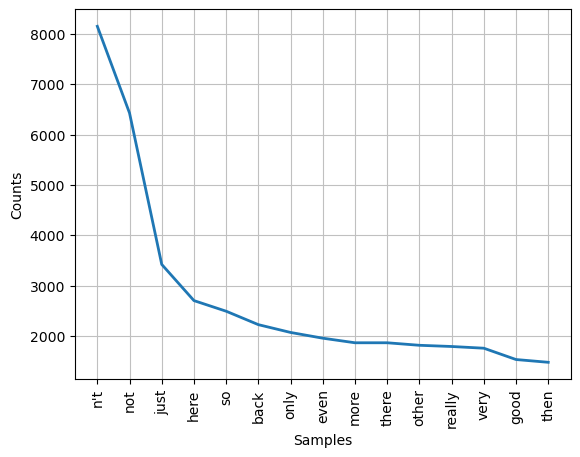

In [74]:
# Generate frequency for the top negative words
freq_dist = nltk.FreqDist(negative_words)

# Visualizing 
words = dict([(k,v) for k,v in freq_dist.items()])

# create frequency distribution of the filtered words
freq_dist = nltk.FreqDist(words)

# Generate line chart to show the top words
# plot the frequency distribution of the top 50 words
freq_dist.plot(15, cumulative=False)
plt.show()

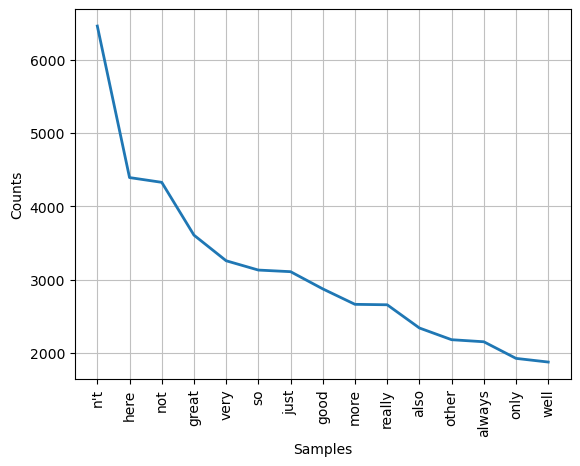

In [75]:
# Generate frequency for the top positive words
freq_dist = nltk.FreqDist(positive_words)

# Visualizing 
words = dict([(k,v) for k,v in freq_dist.items()])

# create frequency distribution of the filtered words
freq_dist = nltk.FreqDist(words)

# plot the frequency distribution of the top 50 words
freq_dist.plot(15, cumulative=False)
plt.show()

Based on the top adjective/adverb words found in both sentiments, both share almost the same top 15 words. Therefore, I will add some of the top words to the stopword list for removal:

'n't', 'not', 'here', 'so', 'just', 'really', 'very', 'only', 'more', 'other'

Removing these common words reduces the overlapping common words among the two sentiments and allows the model to weigh the more important words and classify the texts more distinctively.

### Pattern Removal

These pattern words include links, domain websites, http, sql texts. These words do not provide any detail toward the text's sentiment and are considered noise which may cause the model to perform poorly with the presence of these words. Therefore, I will remove them through pattern matching.

Additionally, the negator words such as "don't" are converted to "dont" so that they will not be removed from the stopword list which contains negator words that have apostrophe only e.g., "don't".

Lastly, removing numbers, punctuations, and new line codes found previously when displaying the head of the dataframe.

In [76]:
# Store reviews in a variable
reviews = [review.lower() for review in df2['text']]

In [77]:
# Removing pattern specific words.

# This patterns remove all links that start with \\/
link_pattern = '\B((\\\\\/)+[\\\/.a-zA-Z0-9_~=-]+)'

# This pattern removes all links that end with some common domain names
domain_pattern = '([\\\/\w\d\.\_\=\-]+)(\.('+regex_domain_names+')|:)([\\\/\w\d\.\_\=\-]+)?'

# SQL like or version statements
sql_pattern = '([a-zA-Z0-9]+)=(\w+[^a-zA-Z\s]+\w+)+'

# This removes all http in text
http_pattern = '(\w+)?(http)(\w+)?'

# This ensures negator words are kept.
# Negator words invert the polarity of the sentiment bearing word directly following the negation word
# Therefore, it is important to keep negator words in the text to prevent the model from assigning 
# a negative text a positive sentiment
apostrophe_pattern = '\''

# Numbers or Symbols
other_pattern = '[^a-zA-Z\s]'

# New Line
new_pattern = '\n'

In [78]:
for index in range(len(reviews)):
    reviews[index] = re.sub(link_pattern, '', reviews[index])
    reviews[index] = re.sub(domain_pattern, '', reviews[index])
    reviews[index] = re.sub(sql_pattern, '', reviews[index])
    reviews[index] = re.sub(http_pattern, '', reviews[index])
    reviews[index] = re.sub(apostrophe_pattern, '', reviews[index])
    reviews[index] = re.sub(other_pattern, ' ', reviews[index])
    reviews[index] = re.sub(new_pattern, ' ', reviews[index])

In [79]:
# Storing the cleaned reviews in the dataframe
df2['text'] = reviews

In [80]:
# Removing the useless column
df2 = df2.drop(columns=['POS_review', 'adj_adv'])

In [81]:
df2.head()

,text,sentiment
0,bi lo is notoriously inconsistent in the quality of their stores but the albemarle road location exceeded my expectations spacious varied in selection and low prices the kicker is yet to come on both trips to this bi lo the produce has been surprisingly fresh a head of romaine lettuce is a mere the fruit is kind lacking but thats why compare foods is around the corner the bakery is always baking something fresh and the meats look quite appealing unlike other bi los i didnt notice this location trying to hawk expired foods i guess i keep shopping here because its cheap like aldis but has the selection like a normal grocery store anyway the kicker is that the reward you with gas savings if you buy like worth of groceries youll get per gallon off from several gas stations no joke please keep in mind that this is albemarle rd so id avoid grocery trips after dark otherwise youll be pleasantly surprised that a decent grocery store exists in east charlotte,1
1,blackwells on south bridge is not only a bookshop its a labyrinth seriously you could get lost in here spread out over three floors this shop caters for all your literary needs as its closely affiliated with edinburghs universities there is a comprehensive academic department covering everything from medicine to media studies and the staff can provide useful guidance if youre feeling a little overwhelmed by it all if youre here for something more recreational the ground floor is a good place to while away an afternoon browsing the shelves there is also a music department with a lot of scottish and classical cds and a nice childrens department in the basement cafe nero has cleverly set up camp in here too so you can start your new tome with a cup of coffee in hand without even leaving the building unfortunately there is no student discount although there is a loyalty card scheme and it cant rival amazons prices but the shop is open pretty late and i think its the best large bookshop in edinburgh,1
2,i generally loathe salespeople and almost didnt purchase my iphone yesterday because i couldnt do it online i walked line the store ready to smack down the first pushy salesperson like an annoying knat but my sales guy chase completely surprised me he saw that i knew what i wanted and spared me the upsell bull that makes me want to kill he even pointed our a discount i was eligible for without me asking about it in the end chase made this a surprisingly painless deal i dont know if the entire staff operates line chase but i know they should,1
3,i dont write lengthy reviews so here it goes great place excellent popcorn by any standard the flavors are well balanced i got the caramel sour apple awesome and my wife got the marilyn monroe coconut white chocolate again awesome it was fresh when we got it and my wifes is even fresh days later dont ask why it is lasting that long she has major self control mine was gone in hours well done on concept and execution,1
4,this is the best thai food i have experienced in toronto and quite possibly the best i have had period both the food and service are amazing the restaurant is deceiving from the outside based on the restaurant location however the interior decor is warm inviting and quaint suitable for a casual friendly get together yet would be a wonderful spot for a romantic dinner as well whether dining in or taking out mengrai will surely not disappoint great value for the money too i suggest the mango salad cold spring rolls and the green thai curry with chicken and basil of course their signature pineapple dish is worth the experience as well great place for gluten free and dairy free diet requirements,1


### Create Frequency Distribution of all words

Frequency Distribution will calculate the number of occurence of each word in the entire list of words.

In [82]:
# All words in the reviews
from nltk.tokenize import word_tokenize

all_words = [word.lower() for sent in df2.text for word in word_tokenize(sent)]

In [83]:
all_words_frequency = FreqDist(all_words)
print (all_words_frequency)

# print 10 most frequently occurring words
print (all_words_frequency.most_common(10))

<FreqDist with 45043 samples and 2118368 outcomes>
[('the', 91982), ('i', 65843), ('and', 64004), ('to', 58940), ('a', 55467), ('of', 35386), ('in', 28925), ('for', 25771), ('is', 24514), ('was', 22897)]


Before data cleaning, most of the words are stopwords and have little meaning to the sentiment analysis.

### Removing Punctuation and Stopwords

From the above frequency distribution of words, we can see the most frequently occurring words are either punctuation marks or stopwords.

Stop words are those frequently words which do not carry any significant meaning in text analysis. For example, I, me, my, the, a, and, is, are, he, she, we, etc.

Punctuation marks like comma, fullstop. inverted comma, etc. occur highly in any text data.

We will do **data cleaning** by removing stop words and punctuations.

In [84]:
# Function for cleaning the texts

import string
from nltk.corpus import stopwords
from gensim.parsing.porter import PorterStemmer

porter_stemmer = PorterStemmer()
stopwords_english = stopwords.words('english')
stopwords_english.extend(["n't", 'not', 'here', 'so', 'just', 'really', 'very', 'only', 'more', 'other'])

def clean(doc):
    all_words_clean = []
    for word in doc:
        # Remove stopwords and numbers
        if word not in stopwords_english and not word.isdigit():
            
            # Removing punctuations
            punc_free = ''.join([ch for ch in word if ch not in string.punctuation])
            
            # Removing words that have lengths less than 2 as words less than 2 usually provide little to no insights due to low meaning
            if len(punc_free)>2 and not word.isdigit():
                
                # Stemming the words.
                all_words_clean.append(porter_stemmer.stem(punc_free))
                # Stemming is used to reduce the dimensionality of words in the dataframe.
                # Since there is more than 15k texts in the dataframe, there are lots of unique terms and high dimensions.
                # Therefore, stemming is used to reduce the size and complexity of the dataframe, and improve the performance.

    return all_words_clean

cleaned_words = clean(all_words)

In [85]:
# Create a frequency distribution of the words after cleaning
all_words_frequency = FreqDist(cleaned_words)
print (all_words_frequency)

print (all_words_frequency.most_common(10))

# get 2000 frequently occuring words
# most documents would have at least some words from the top 2000 words. Therefore, it might be a better feature set for
# classification.
most_common_words = all_words_frequency.most_common(2000)

# create word features
all_word_features = [item[0] for item in most_common_words]

<FreqDist with 31116 samples and 1053340 outcomes>
[('store', 12598), ('on', 8319), ('like', 8306), ('get', 8155), ('place', 7581), ('shop', 7002), ('time', 6889), ('look', 6240), ('would', 5824), ('price', 5414)]


Previously, before removing stopwords and punctuation, the frequency distribution was:

> **FreqDist with 45062 samples and 2118861 outcomes**

Now, the frequency distribution is:

> **FreqDist with 31130 samples and 1053656 outcomes**

This shows that after removing around 1000000 stop words, numbers and punctuation, the outcomes/words number has reduced to around half of the original size.

Before, the first 10 frequently occurring words were only stop-words and punctuations. Now, the **most common words** or highly occurring words list has meaningful words in the list. 

## Feature Extraction

Creating these feature sets have long computational time. Estimated run time is roughly 45minutes.

In [86]:
# Create Feature Set
df2['text_tokens'] = df2['text'].apply(lambda x: word_tokenize(x.lower()))
df2['text_tokens'] = df2['text_tokens'].apply(lambda x: clean(x))  
df2.head()

,text,sentiment,text_tokens
0,bi lo is notoriously inconsistent in the quality of their stores but the albemarle road location exceeded my expectations spacious varied in selection and low prices the kicker is yet to come on both trips to this bi lo the produce has been surprisingly fresh a head of romaine lettuce is a mere the fruit is kind lacking but thats why compare foods is around the corner the bakery is always baking something fresh and the meats look quite appealing unlike other bi los i didnt notice this location trying to hawk expired foods i guess i keep shopping here because its cheap like aldis but has the selection like a normal grocery store anyway the kicker is that the reward you with gas savings if you buy like worth of groceries youll get per gallon off from several gas stations no joke please keep in mind that this is albemarle rd so id avoid grocery trips after dark otherwise youll be pleasantly surprised that a decent grocery store exists in east charlotte,1,"[notori, inconsist, qualiti, store, albemarl, road, locat, exceed, expect, spaciou, vari, select, low, price, kicker, yet, come, trip, produc, surprisingli, fresh, head, romain, lettuc, mere, fruit, kind, lack, that, compar, food, around, corner, bakeri, alwai, bake, someth, fresh, meat, look, quit, appeal, unlik, lo, didnt, notic, locat, try, hawk, expir, food, guess, keep, shop, cheap, like, aldi, select, like, normal, groceri, store, anywai, kicker, reward, ga, save, bui, like, worth, groceri, youll, get, per, gallon, sever, ga, station, joke, pleas, keep, mind, albemarl, avoid, groceri, trip, dark, otherwis, youll, pleasantli, surpris, decent, groceri, store, exist, east, charlott]"
1,blackwells on south bridge is not only a bookshop its a labyrinth seriously you could get lost in here spread out over three floors this shop caters for all your literary needs as its closely affiliated with edinburghs universities there is a comprehensive academic department covering everything from medicine to media studies and the staff can provide useful guidance if youre feeling a little overwhelmed by it all if youre here for something more recreational the ground floor is a good place to while away an afternoon browsing the shelves there is also a music department with a lot of scottish and classical cds and a nice childrens department in the basement cafe nero has cleverly set up camp in here too so you can start your new tome with a cup of coffee in hand without even leaving the building unfortunately there is no student discount although there is a loyalty card scheme and it cant rival amazons prices but the shop is open pretty late and i think its the best large bookshop in edinburgh,1,"[blackwel, south, bridg, bookshop, labyrinth, serious, could, get, lost, spread, three, floor, shop, cater, literari, need, close, affili, edinburgh, univers, comprehens, academ, depart, cover, everyth, medicin, media, studi, staff, provid, us, guidanc, your, feel, littl, overwhelm, your, someth, recreat, ground, floor, good, place, awai, afternoon, brows, shelv, also, music, depart, lot, scottish, classic, cd, nice, children, depart, basement, cafe, nero, cleverli, set, camp, start, new, tome, cup, coffe, hand, without, even, leav, build, unfortun, student, discount, although, loyalti, card, scheme, cant, rival, amazon, price, shop, open, pretti, late, think, best, larg, bookshop, edinburgh]"
2,i generally loathe salespeople and almost didnt purchase my iphone yesterday because i couldnt do it online i walked line the store ready to smack down the first pushy salesperson like an annoying knat but my sales guy chase completely surprised me he saw that i knew what i wanted and spared me the upsell bull that makes me want to kill he even pointed our a discount i was eligible for without me asking about it in the end chase made this a surprisingly painless deal i dont know if the entire staff operates line chase but i know they should,1,"[gener, loath, salespeopl, almost, di

### Creating a Feature Set

Creating a feature set of the top 2000 words for dimensionality reduction. The model will look at the presence of frequently occuring words in the texts to classify the texts, rather than looking at words with only a few occurrence among multiple texts which may not be accurate in classification.

In [87]:
# Feature set with only the top 2000 
def document_features(df, stemmed_tokens):
    doc_features = []
    for index, row in df.iterrows():
        features = {}
        for word in all_word_features:
            # get term occurence: true if it's in the word_features, false if it's not
            features[word] = (word in row[stemmed_tokens])
        doc_features.append(features)
    return doc_features

all_words_feature_set = pd.DataFrame(document_features(df2, 'text_tokens'), index = df2.index)
all_words_feature_set.head()

,store,on,like,get,place,shop,time,look,would,price,...,electr,rid,kohl,degre,field,stuttgart,verk,lie,enjoy,librari
0,True,False,True,True,False,True,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,True,True,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


### Create Term Frequency (TF) Bag of Words

A Term Frequency Bag of Words generates a collection of text documents into numerical feature vectors. This might provide a better performance than a normal Bag of Words as it shows the occurrence of individual terms in the text which may increase the sentiment of the text.

In [88]:
import gensim
from gensim import corpora

# Build the dictionary
mydict = corpora.Dictionary(df2['text_tokens'])
vocab_len = len(mydict)

def get_bow_features(df, stemmed_tokens):
    test_features = []
    for index, row in df.iterrows():
        # Converting the tokens into the format that the model requires
        features = gensim.matutils.corpus2csc([mydict.doc2bow(row[stemmed_tokens])],num_terms=vocab_len).toarray()[:,0]
        test_features.append(features)
    return test_features

header = ",".join(str(mydict[ele]) for ele in range(vocab_len))

bow_all_word_features = pd.DataFrame(get_bow_features(df2, 'text_tokens'),                            
                            columns=header.split(','), index = df2.index)

bow_all_word_features.head()

,albemarl,aldi,alwai,anywai,appeal,around,avoid,bake,bakeri,bui,...,bidul,dendroit,foutoir,giqu,quautr,typiqu,ussi,wellesli,differnt,movign
0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Create Term Frequency-Inverse Document Frequency (TF-IDF) Bag of Words

TF-IDF Assigns more weight to rare words and less weight to commonly occurring words. It tells us how frequent a word is in a document relative to its frequency in the entire corpus and evaluates the importance of a term in a corpus (a large set of text).

In [89]:
from gensim.models import TfidfModel

# Build the dictionary
mydict = corpora.Dictionary(df2['text_tokens'])
vocab_len = len(mydict)
corpus = [mydict.doc2bow(line) for line in df2['text_tokens']]
tfidf_model = TfidfModel(corpus)

def get_tfidf_features(df, stemmed_tokens):
    test_features_tfidf = []
    for index, row in df.iterrows():
        doc = mydict.doc2bow(row[stemmed_tokens])
        # Converting the tokens into the formet that the model requires
        features = gensim.matutils.corpus2csc([tfidf_model[doc]], num_terms=vocab_len).toarray()[:,0]
        test_features_tfidf.append(features)
    return test_features_tfidf

header = ",".join(str(mydict[ele]) for ele in range(vocab_len))

tfidf_all_words_features = pd.DataFrame(get_tfidf_features(df2, 'text_tokens'),                            
                            columns=header.split(','), index = df2.index)
tfidf_all_words_features.head()

,albemarl,aldi,alwai,anywai,appeal,around,avoid,bake,bakeri,bui,...,bidul,dendroit,foutoir,giqu,quautr,typiqu,ussi,wellesli,differnt,movign
0,0.391642,0.151165,0.038396,0.070178,0.097369,0.039835,0.077295,0.10626,0.102431,0.0351,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modelling

In the modelling section, I will be using the following models for sentiment classification:
1. Random Forest
2. Logistic Regression
3. Extreme Gradient Boosting (XGB) Classifier

Random Forest Classifier is an ensemble method that creates and uses the result of multiple decision trees to make a prediction; it can handle non-linear relationships and high-dimensional data. It also has the feature_importances_ attribute, which reveals which features are influential in determining the sentiment of a text. 

Logistic Regression is a linear model that models the relationship between the features and the target variable as a linear combination. Logistic Regression also has the coef_ attribute, revealing the weight of terms in the two sentiment classes. Additionally, it can handle large datasets and be tuned to be more regularized to avoid overfitting, making it a good choice for sentiment analysis.

As with Random Forest Classifiers, XGBoost combines multiple decision trees to make predictions. Therefore, it can handle non-linear relationships and high-dimensional data. It can also handle large datasets and has the feature_importances_ attrbiute which can be used to understand what features are important in determining the sentiment of a text.

Therefore, I will use these 3 models due to its good performance and classification approaches.

### Evaluation Criteria

AUC-ROC is a metric that measures the ability of a model to distinguish between positive and negative classes. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold values and computes the area under the resulting curve.

The AUC-ROC is a robust metric that is insensitive to class imbalance, so it can be used to evaluate the performance of the sentiment analysis model with a class distribution of 60:40 for positive:negative respectively. A high AUC-ROC value indicates that the model is able to distinguish between positive and negative instances, regardless of the class distribution.

ROC-AUC is expressed as a decimal value ranging from 0 to 1.

A value of 0.5 represents a random guess, while a value of 1 represents a perfect model that perfectly separates positive and negative classes. A value of 0 represents a model that performs worse than random guessing.

 Thus, I will look for a model that produces the highest AUC-ROC score.

In [90]:
# pip install xgboost

In [91]:
# Import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Import metric scores
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Import train test split and seaborn
import seaborn as sns
from sklearn.model_selection import train_test_split

In [92]:
# Specifying the random_state to ensure reproducable results
models = []
models.append(('LR', LogisticRegression(random_state=1)))
models.append(('RF', RandomForestClassifier(random_state=1)))
models.append(('XGB', XGBClassifier(random_state=1)))

### Testing with Feature Set

Train the LR model now.


C:\Users\fangg\anaconda3_new\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train the RF model now.
Train the XGB model now.


,Name,ROC-AUC
0,LR,0.855384
2,XGB,0.843417
1,RF,0.830711


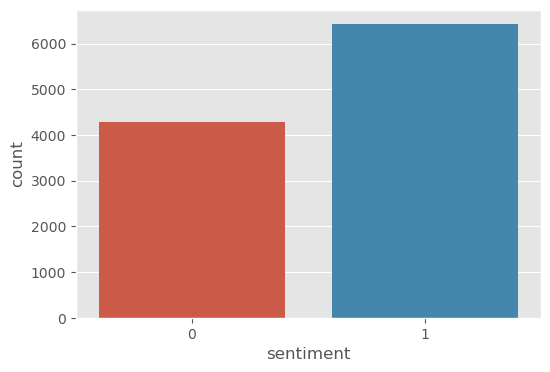

In [93]:
X = all_words_feature_set # x is the columns, pass into the model
y = df2[df2.columns[1:2]] # y is the target variable, sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # Stratify by the y column

#plot chart
plt.style.use('ggplot')
plt.figure(figsize=(6,4))
sns.countplot(data=y_train, x='sentiment')

# Testing with Kfold cross-validation and 10 folds.
from sklearn.model_selection import KFold
import sklearn.model_selection as model_selection

names = []
scores = []
for name,model in models:
    print("Train the",name,"model now.")
    
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    scores.append(roc_auc_score(y_test, y_pred))
    names.append(name)

models_comparison = pd.DataFrame({'Name':names, 'ROC-AUC':scores})
models_comparison.sort_values(by='ROC-AUC', ascending=False)

Based on the results of the classifiers, Random Forest has the best ROC-AUC score of 85.53%. The classes after splitting the data into train data is also quite balanced of around 40%:60% in the negative (0) and positive (1) sentiment respective.

### Testing with Term Frequency Bag of Words

Train the LR now.


C:\Users\fangg\anaconda3_new\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train the RF now.
Train the XGB now.


,Name,ROC-AUC
0,LR,0.863556
2,XGB,0.851772
1,RF,0.828007


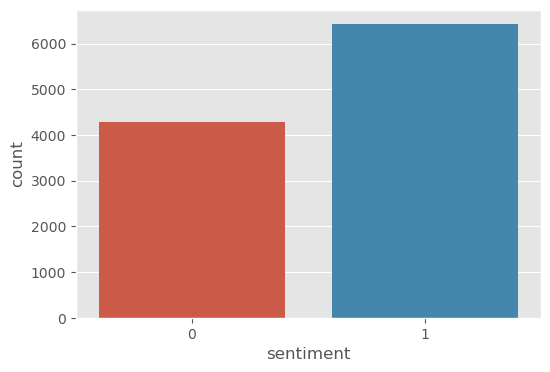

In [94]:
X = bow_all_word_features # x is the columns, pass into the model
y = df2[df2.columns[1:2]] # y is the target variable, sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # Stratify by the y column

#plot chart
plt.style.use('ggplot')
plt.figure(figsize=(6,4))
sns.countplot(data=y_train, x='sentiment')


names = []
scores = []
for name,model in models:
    print("Train the",name,"now.")
    
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    scores.append(roc_auc_score(y_test, y_pred))
    names.append(name)

models_comparison = pd.DataFrame({'Name':names, 'ROC-AUC':scores})
models_comparison.sort_values(by='ROC-AUC', ascending=False)

Compared to using the top 2000 feature set containing all words, the Term Frequency Bag of Words Feature Set performed better, with the highest ROC-AUC being 86.35% compared to 85.53% previously.

This improvement in performance could be due to the higher occurrence of certain terms within the text that enabled the model to better assign a higher likelihood that the text belongs to a certain class.

In addition, the Term Frequency Bag of Words contains more words like adjectives and adverbs, which may be crucial in classifying the texts, whereas only 2000 words are present in the top 2000 feature set.

### Testing with a feature of TF-IDF Bag of Words

Train the LogisticRegression(random_state=1) now.
Train the RandomForestClassifier(random_state=1) now.
Train the XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...) now.


,Name,ROC-AUC
0,LR,0.863131
2,XGB,0.850770
1,RF,0.811694


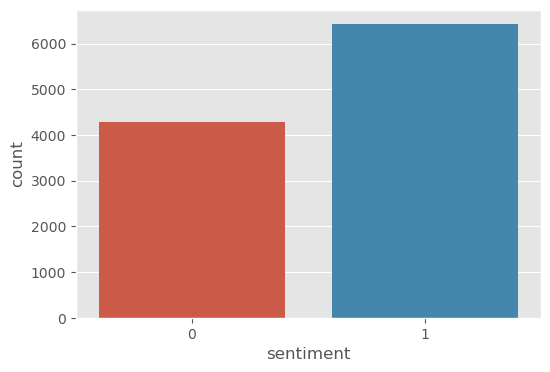

In [95]:
X = tfidf_all_words_features # x is the columns, pass into the model
y = df2[df2.columns[1:2]] # y is the target variable, sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # Stratify by the y column

#plot chart
plt.style.use('ggplot')
plt.figure(figsize=(6,4))
sns.countplot(data=y_train, x='sentiment')

names = []
scores = []
for name,model in models:
    print("Train the",name,"now.")
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    scores.append(roc_auc_score(y_test, y_pred))
    names.append(name)

models_comparison = pd.DataFrame({'Name':names, 'ROC-AUC':scores})
models_comparison.sort_values(by='ROC-AUC', ascending=False)

Compared to using the top 2000 feature set containing all words, the TF-IDF Bag of Words Feature Set performed slightly worse, with the highest accuracy being 86.31% compared to 86.35% previously.

This decrease in performance could be due to the fact that TF-IDF assigned more weight to rare words and less weight to commonly occurring words, which could have been crucial in classifying the text's sentiment.

### Selecting best model

Based on the 3 different feature sets and models, the Random Forest with a feature set of Term Frequency of All Words BOW performed the best. It has a classification accuracy of 84.5%. Therefore, I decided to tune this model to achieve better results.

In [97]:
X = bow_all_word_features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [98]:
names = []
scores = []

In [99]:
classifier = LogisticRegression(random_state=1)
classifier.fit(X_train, y_train.values.ravel())

names.append("Non-tuned (LBFGS solver, C=1) model")
y_pred = classifier.predict(X_test) 
roc_score = roc_auc_score(y_test, y_pred)
scores.append(roc_score)
print("ROC_AUC Score: " + str(roc_score))

C:\Users\fangg\anaconda3_new\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC_AUC Score: 0.863556222540544


An error message shows that maximum iterations met. I will consider increasing iterations later.

### Model Tuning

I will try tuning the different model's parameter to improve the classification accuracy.

In [100]:
print("Possible parameters to be tuned for the Logistic Regression Classifier:")
LogisticRegression().get_params().keys()

Possible parameters to be tuned for the Logistic Regression Classifier:


dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

Of these parameters, I will only tune the following parameters:
    
C - C is the inverse of regularization strength. the default C value is 1.0. a smaller value specifies stronger regularization. tuning the regularization strength may increase the generalization performance of unseen data.

solver - The default solver is 'lbfgs'. 'saga' is a suitable optimization algorithm for logistic regression models when handling sparse data, large-scale datasets, or when L1 regularization is used. Therefore, I test the 'saga' solver for optimzation problem.

max_iter - Increasing the maximum number of iterations in a logistic regression model may improve sentiment classification accuracy as it allows convergence. However, it depends on the other parameters.

In [101]:
classifier = LogisticRegression(max_iter=200, random_state=1)
classifier.fit(X_train, y_train.values.ravel())

names.append("Tuned (LBFGS solver, C=1, Max Iter=200) model")
y_pred = classifier.predict(X_test) 
roc_score = roc_auc_score(y_test, y_pred)
scores.append(roc_score)
print("ROC_AUC Score: " + str(roc_score))

ROC_AUC Score: 0.863556222540544


Increasing the max iterations did not change the ROC_AUC score. The lbfgs managed to converge yet the ROC_AUC score continues to be at 0.8635. Therefore, I will continue to use a max_iteration of 100 since there is no change in performance.

In [103]:
# Trying a stronger regularization.
classifier = LogisticRegression(C=0.5,  random_state=1)
classifier.fit(X_train, y_train.values.ravel())

names.append("Tuned (C=0.5, LBFGS solver) Model")
y_pred = classifier.predict(X_test) 
roc_score = roc_auc_score(y_test, y_pred)

scores.append(roc_score)
print("ROC_AUC Score: " + str(roc_score))

C:\Users\fangg\anaconda3_new\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC_AUC Score: 0.8653746338986545


With a stronger regularization, lower C value, the performance improved to 86.53%. A stronger generalization may have caused the model to be less underfit, being able to capture the true relationship between the variables, thus improving the classification performance.

In [104]:
# Trying a stronger regularization with SAGA solver
classifier = LogisticRegression(C=0.5, solver='saga', random_state=1)
classifier.fit(X_train, y_train.values.ravel())

names.append("Tuned (C=0.5, SAGA solver) Model")
y_pred = classifier.predict(X_test) 
roc_score = roc_auc_score(y_test, y_pred)

scores.append(roc_score)
print("ROC_AUC Score: " + str(roc_score))

C:\Users\fangg\anaconda3_new\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


ROC_AUC Score: 0.8686488428911979


When using both SAGA solver and a C value of 0.5, the ROC_AUC performed the best. A C value of 0.5 provides a stronger regularization for the dataset, reducing underfitting. SAGA, an optimzation solver, can handle sparse data better than LBFGS. These two benefits combined produces the best results, an ROC_AUC score of 86.86%.

# Evaluation - Best Model

In [105]:
models_comparison = pd.DataFrame({'Name':names, 'ROC-AUC':scores})
models_comparison.sort_values(by='ROC-AUC', ascending=False)

,Name,ROC-AUC
3,"Tuned (C=0.5, SAGA solver) Model",0.868649
2,"Tuned (C=0.5, LBFGS solver) Model",0.865375
0,"Non-tuned (LBFGS solver, C=1) model",0.863556
1,"Tuned (LBFGS solver, C=1, Max Iter=200) model",0.863556


The best model is the Logistic Regression with a C value of 1 and the SAGA solver. It has an ROC_AUC value of 86.86%.

In [104]:
# Trying a stronger regularization with SAGA solver
classifier = LogisticRegression(C=0.5, solver='saga', random_state=1)
classifier.fit(X_train, y_train.values.ravel())

names.append("Tuned (C=0.5, SAGA solver) Model")
y_pred = classifier.predict(X_test) 
roc_score = roc_auc_score(y_test, y_pred)

scores.append(roc_score)
print("ROC_AUC Score: " + str(roc_score))

C:\Users\fangg\anaconda3_new\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


ROC_AUC Score: 0.8686488428911979


              precision    recall  f1-score   support

    positive       0.87      0.82      0.84      1837
    negative       0.88      0.92      0.90      2751

    accuracy                           0.88      4588
   macro avg       0.88      0.87      0.87      4588
weighted avg       0.88      0.88      0.88      4588

ROC_AUC Score: 0.8686488428911979
Accuracy Score: 0.8781604184829991


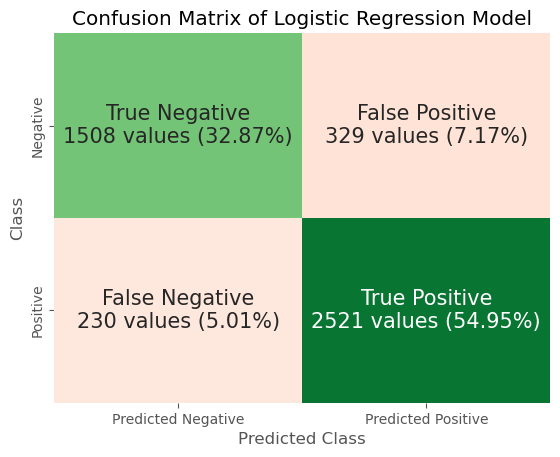

In [106]:
cm = confusion_matrix(y_test, y_pred)

names = ['True Negative','False Positive','False Negative','True Positive']
counts = ["{0:0.0f} values".format(value) for value in cm.flatten()]
percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2} ({v3})" for v1, v2, v3 in zip(names,counts,percentages)]
labels = np.asarray(labels).reshape(2,2)
ycategories = ['Negative', 'Positive']
xcategories = ['Predicted Negative', 'Predicted Positive']
off_diag_mask = np.eye(*cm.shape, dtype=bool)

fig = plt.figure()
con_mat = sns.heatmap(cm, annot=labels, annot_kws={"size": 15}, vmin=0, vmax=3000, mask=~off_diag_mask, cmap='Greens', fmt='', cbar=False, yticklabels=ycategories, xticklabels=xcategories)
con_mat = sns.heatmap(cm, annot=labels, annot_kws={"size": 15}, vmin=0, vmax=3000, mask=off_diag_mask, cmap='Reds', fmt='', cbar=False, yticklabels=ycategories, xticklabels=xcategories)
con_mat.set(xlabel="Predicted Class", ylabel="Class", title='Confusion Matrix of Logistic Regression Model')
con_mat

from sklearn.metrics import classification_report, accuracy_score

print(classification_report(y_test, y_pred,target_names=["positive","negative"]))

print("ROC_AUC Score: " + str(roc_auc_score(y_test, y_pred)))
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))

The Logistic Regression's classification is good with majority (87.82%) of the the texts being correct classification. Meanwhile, the false positive and negative rate is low at only 12.18%. 

A value of 0.5 represents a random guess, while a value of 1 represents a perfect model that perfectly separates positive and negative classes. A value of 0 represents a model that performs worse than random guessing. The classification has a high ROC_AUC score of 86.82%, which is roughly 15% away from being a perfect model. 

### Top words used for classification of a text

In [107]:
# Coefficients represent the relationship between the given feature and the target , 
# assuming that all the other features remain constant (conditional dependence).

# Positive coefficient belong to the positive sentiment class.
importances = list(classifier.coef_[0])
feature_importances = [(feature, round(importance, 10)) for feature, importance in zip(bow_all_word_features.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

top_i = 0
print("Top 10 keywords that classify a text to the positive sentiment:")
for pair in feature_importances:
    print('Variable: {:10} Importance: {}'.format(*pair))
    if top_i == 10:
        break
    top_i += 1

Top 10 keywords that classify a text to the positive sentiment:
Variable: awesom     Importance: 1.0802697454
Variable: amaz       Importance: 1.075789988
Variable: great      Importance: 1.0617349836
Variable: love       Importance: 0.9836114689
Variable: perfect    Importance: 0.91089565
Variable: best       Importance: 0.8339536972
Variable: favorit    Importance: 0.8045344339
Variable: definit    Importance: 0.7972994575
Variable: friendli   Importance: 0.7773609381
Variable: fantast    Importance: 0.7574508078
Variable: thank      Importance: 0.7552324906


In [108]:
# Coefficients represent the relationship between the given feature and the target , 
# assuming that all the other features remain constant (conditional dependence).

# Negative coefficient belong to the negative sentiment class.
importances = list(classifier.coef_[0])
feature_importances = [(feature, round(importance, 10)) for feature, importance in zip(bow_all_word_features.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# for pair in feature_importances:
#     print(pair)

importances = [(name, value) for (name,value) in feature_importances]
importances.sort(key=lambda i:i[1], reverse=False)
top_i = 0
print("Top 10 keywords that classify a text to the negative sentiment:")
for pair in importances:
    print('Variable: {:10} Importance: {}'.format(*pair))
    if top_i == 10:
        break
    top_i += 1

Top 10 keywords that classify a text to the negative sentiment:
Variable: disappoint Importance: -1.4782812588
Variable: rude       Importance: -1.4772943767
Variable: worst      Importance: -1.2953428402
Variable: horribl    Importance: -1.2200427237
Variable: overpr     Importance: -0.8970383423
Variable: poor       Importance: -0.8782863496
Variable: terribl    Importance: -0.8577892175
Variable: wors       Importance: -0.7272375992
Variable: bother     Importance: -0.7145863619
Variable: wast       Importance: -0.6989120573
Variable: sad        Importance: -0.6958086705


These are the top 10 features that are mostly used to classify a text to the postivie/negative sentiment. The terms are mostly adverbs/adjectives such as 'awesom' or 'disappoint'. Therefore, adjectives/adverbs are necessary in sentiment analysis.

This also shows how well the Logistic Regression classifier learns from the data as all the terms used to classify the positive/negative sentiments in the model are correct terms used to determine the sentiment of a text from a human's perspective.

## Submission
Export your completed work as HTML. Select **File** > **Download as** > **HTML (.html)**.